# Zadatak 2

Generisati po $𝑁 = 500$ odbiraka iz dveju dvodimenzionih bimodalnih klasa: $$\Omega_1 \sim  P_{11} \cdot N(M_{11}, \Sigma_{11}) + P_{12} \cdot N(M_{12}, \Sigma_{12})$$   $$\Omega_2 \sim  P_{21} \cdot N(M_{21}, \Sigma_{21}) + P_{22} \cdot N(M_{22}, \Sigma_{22})$$  

Parametre klasa samostalno izabrati. 

a) Na dijagramu prikazati odbirke. 

b) Iscrtati kako teorijski izgledaju funkcije gustine verovatnoće za raspodele klasa i uporediti ih sa histogramom 
generisanih odbiraka. 

c) Projektovati Bajesov klasifikator minimalne greške i na dijagramu, zajedno sa odbircima, skicirati klasifikacionu liniju. 
Uporediti grešku klasifikacije konkretnih odbiraka sa teorijskom greškom klasifikacije prve i druge vrste za datu 
postavku. 

d) Projektovati klasifikator minimalne cene tako da se više penalizuje pogrešna klasifikacija odbiraka iz prve klase. 

e) Ponoviti prethodnu tačku za Neuman-Pearson-ov klasifikator. Obrazložiti izbor $\epsilon_2 = \epsilon_0$. 

f) Za klase oblika generisanih u prethodnim tačkama, projektovati Wald-ov sekvencijalni test pa skicirati zavisnost broja 
potrebnih odbiraka od usvojene verovatnoće grešaka prvog, odnosno drugog tipa. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix

In [48]:
import seaborn as sns
import scipy
from skimage import io
import os
from sklearn.metrics import confusion_matrix

## a)

Prvo podešavamo parametre za dati problem

In [40]:
np.random.seed(0)
N = 500 
P1, P2 = 0.5, 0.5

P11, P12 = 0.3, 0.7
M11 = np.array([-0.7, 0.6]).reshape(-1, 1)
S11 = np.array([[0.7, 0.2], [0.2, 0.7]])
M12 = np.array([4, 4]).reshape(-1, 1)
S12 = np.array([[2, -0.3], [-0.3, 2]])

P21, P22 = 0.4, 0.6
M21 = np.array([-3, 1]).reshape(-1, 1)
S21 = np.array([[1, 0.7], [0.7, 1]])
M22 = np.array([-5, 4]).reshape(-1, 1)
S22 = np.array([[1, 0.1], [0.1, 1]])

Zatim vršimo nasumično uzorkovanje iz odgovarajućih raspodela - ovo predstavlja generisanje naših odbiraka.

In [41]:
X11 = np.random.multivariate_normal(M11.reshape(-1),S11,N)
X12 = np.random.multivariate_normal(M12.reshape(-1),S12,N)
X21 = np.random.multivariate_normal(M21.reshape(-1),S21,N)
X22 = np.random.multivariate_normal(M22.reshape(-1),S22,N)

pp = np.random.rand(1,N)
p = np.concatenate((pp,pp),axis=0).T
X1 = (p<P11)*X11 + (p>=P11)*X12

pp = np.random.rand(1,N)
p = np.concatenate((pp,pp),axis=0).T
X2 = (p<P21)*X21 + (p>=P21)*X22

### Prikaz odbiraka

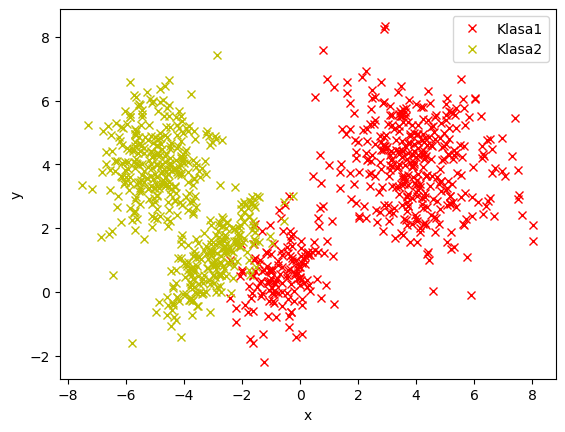

In [42]:
plt.figure()
plt.plot(X1[:,0],X1[:,1],'rx')
plt.plot(X2[:,0],X2[:,1],'yx')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Klasa1', 'Klasa2'])
plt.show()

Postoji preklapanje između klasa - zbog ovoga klasifikatori neće imati potpunu tačnost, ali je ovakav primer podoban za ilustraciju karakteristika različitih klasifikatora

### b)

#### Prikaz fgv

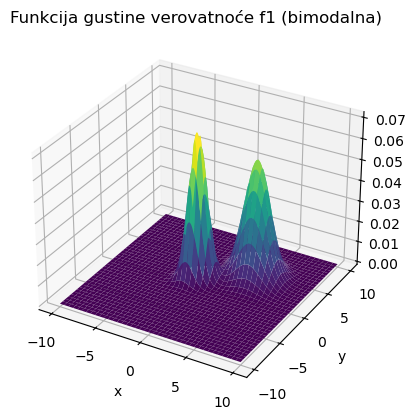

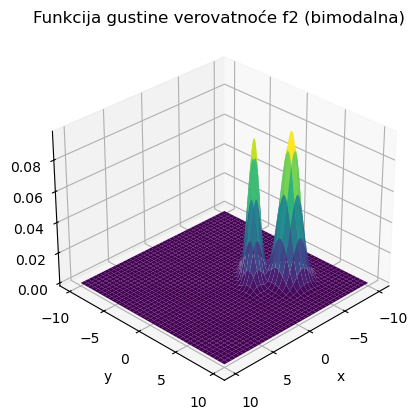

In [59]:
x = np.arange(-10,10.1,0.1)      #levu granicu inkluzivno, desnu eksluzivno
y = np.arange(-10,10.1,0.1)

f11 = np.zeros((len(x),len(y)))
f12 = np.zeros((len(x),len(y)))
f21 = np.zeros((len(x),len(y)))
f22 = np.zeros((len(x),len(y)))
f1 = np.zeros((len(x),len(y)))
f2 = np.zeros((len(x),len(y)))

def gaussian_pdf(X, M, S):
    detS = np.linalg.det(S)
    invS = np.linalg.inv(S)
    f = 1/(2*np.pi*detS**0.5)*np.exp(-0.5*(X-M).T@invS@(X-M))
    return f[0,0]

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(-1,1)
        f11[i,j] = gaussian_pdf(X,M11,S11)
        f12[i,j] = gaussian_pdf(X,M12,S12)
        f21[i,j] = gaussian_pdf(X,M21,S21)
        f22[i,j] = gaussian_pdf(X,M22,S22)
        f1[i,j] = P11*f11[i,j] + P12*f12[i,j]
        f2[i,j] = P21*f21[i,j] + P22*f22[i,j]

X, Y = np.meshgrid(x,y)    

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X,Y,f1.T,cmap='viridis')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Funkcija gustine verovatnoće f1 (bimodalna)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X,Y,f2.T,cmap='viridis')
ax.set_xlabel('x'); ax.set_ylabel('y')
ax.set_title('Funkcija gustine verovatnoće f2 (bimodalna)')
ax.view_init(elev=30, azim=45)
plt.show()

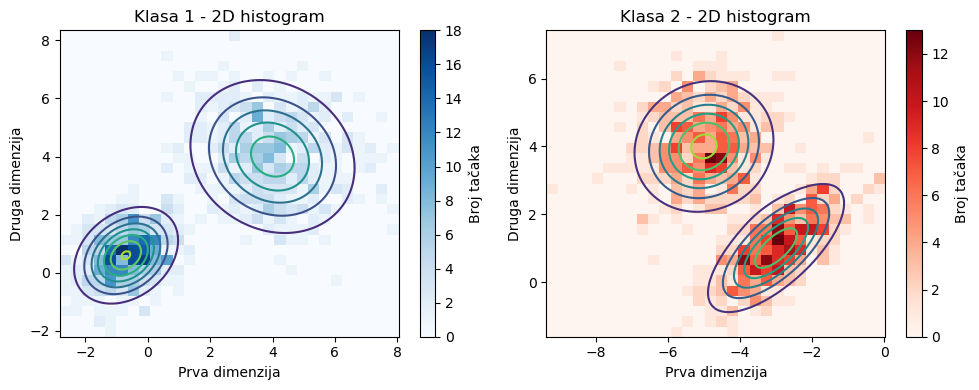

In [45]:
class1 = np.vstack((X11, X12))
class2 = np.vstack((X21, X22))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist2d(class1[:, 0], class1[:, 1], bins=30, cmap='Blues')
plt.colorbar(label='Broj tačaka')
plt.contour(X,Y,f1.T)
plt.title("Klasa 1 - 2D histogram")
plt.xlabel("Prva dimenzija")
plt.ylabel("Druga dimenzija")

plt.subplot(1, 2, 2)
plt.hist2d(class2[:, 0], class2[:, 1], bins=30, cmap='Reds')
plt.colorbar(label='Broj tačaka')
plt.contour(X,Y,f2.T)
plt.title("Klasa 2 - 2D histogram")
plt.xlabel("Prva dimenzija")
plt.ylabel("Druga dimenzija")

plt.tight_layout()
plt.show()

Jasno se vidi preklapanje izohipsi fgv sa hitogramom generisanih odbiraka. Ovo potvrđuje tačnost koda.

### c) Bajesov test minimalne verovatnoće greške

Pretpostavimo dve klase $\omega_1$ i $\omega_2$. Za svaki odbirak (tj. za svaki oblik) potrebno nam je znanje o:
- apriornim verovatnoćama pojava klasa $P(\omega_1)=P_1$ i $P(\omega_2)=P_2$
- gustinama verovatnoće uslovljenim klasom $f(x\mid \omega_1)=f_1(x)$ i $f(x\mid \omega_2)=f_2(x)$.


U praksi $f_i(x)$ često modelujemo Gaussovom raspodelom, a vektor srednje vrednosti i kovariacionu matricu određujemo na osnovu apriornog znanja ili na osnovu odbiraka.

Klasifikator ima za zadatak da na osnovu datih elemenata sračuna aposteriorne verovatnoće za obe klase, uporedi sa granicom i donese odluku.

$\frac{f_1(x)}{f_2(x)}$ poredimo sa pragom $\frac{P_2}{P_1}$. Ukoliko je veći od praga, odbirak pripada klasi 1, u suprotnom pripada klasi 2.

Klasifikaciona linija se često zapisuje i kao: $$h(x) = -ln \left( \frac{f_1(x)}{f_2(x)} \right)$$ tada se prag svodi na $$T = ln \left( \frac{P_1}{P_2} \right)$$ Zbog promene znaka ovde odbirak pripada klasi 1 ako je diskriminaciona funkcija manja od praga, a pripada klasi 2 ukoliko je veća.



U ovom delu uporedićemo pristup gde znamo fgv i koristi parametre koje smo ranije definisali i pristup gde aproksimiramo parametre i koristimo (unimodalnu) gausovsku fgv. Ovo radim kako bih pokazala da je adekvatno nekada modelovati različite fgv gausovskim.

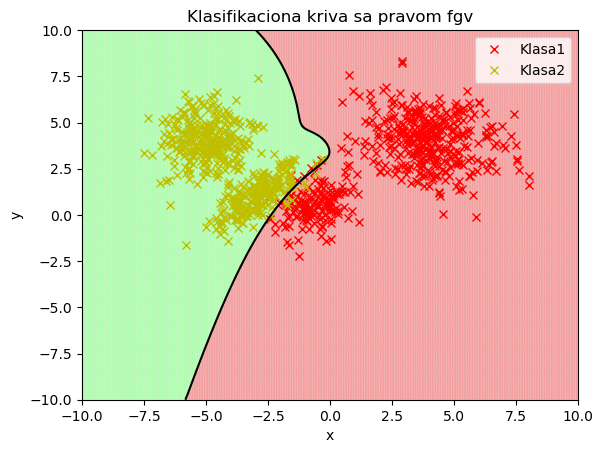

In [60]:
h = np.zeros((len(x),len(y)))
T = np.log(P1/P2)

K1 = np.empty((0,2))
K2 = np.empty((0,2))

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(1,2)
        h[i,j] = -np.log(f1[i,j]/f2[i,j])
        if h[i,j] < T:
            K1 = np.append(K1,X,axis=0)
        else:
            K2 = np.append(K2,X,axis=0)
            
plt.figure()
plt.plot(X1[:,0],X1[:,1],'rx')
plt.plot(X2[:,0],X2[:,1],'yx')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Klasa1', 'Klasa2'])
plt.scatter(K1[:, 0], K1[:, 1], color='lightcoral', alpha=0.3, s=10, edgecolor='none')  
plt.scatter(K2[:, 0], K2[:, 1], color='palegreen', alpha=0.3, s=10, edgecolor='none')
plt.contour(x, y, h.T, levels=[T], colors='black')
plt.title('Klasifikaciona kriva sa pravom fgv')
plt.show()

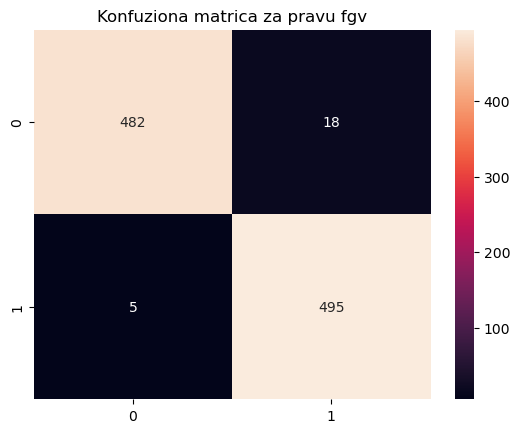

In [61]:
data = np.concatenate((X1,X2),axis=0)

y_true = np.zeros(X1.shape[0]+X2.shape[0]) 
y_true[X1.shape[0]:] = 1
y_predict = np.zeros(np.shape(y_true))

for i in range(0,len(y_true)):
    sample = data[i,:].reshape((-1, 1))
    h = -P11 * np.log(gaussian_pdf(sample,M11,S11)) - P12 * np.log(gaussian_pdf(sample,M12,S12)) + P21 * np.log(gaussian_pdf(sample,M21,S21)) + P22 * np.log(gaussian_pdf(sample,M22,S22))
    y_predict[i] = h>T

cm = confusion_matrix(y_true,y_predict)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Konfuziona matrica za pravu fgv')
plt.show()

Sračunaćemo greške dobijene ovom metodom

In [64]:
eps1b = cm[0,1]/sum(cm[0,:]) 
eps2b = cm[1,0]/sum(cm[1,:])
print(f'Greška prve vrste iznosi: {eps1b:.3f}')
print(f'Greška prve vrste iznosi: {eps2b:.3f}')
e1 = 0
e2 = 0

for i in range(0,len(x)):
    for j in range(0,len(y)):
        if -np.log(f1[i,j]/f2[i,j]) < 0:
            e2 += f2[i,j]*0.1*0.1
        else:
            e1 += f1[i,j]*0.1*0.1
            
print('Greška prve vrste teorijski iznosi: ', e1)
print('Greška druge vrste teorijski iznosi: ', e2)

Greška prve vrste iznosi: 0.036
Greška prve vrste iznosi: 0.010
Greška prve vrste teorijski iznosi:  0.020083858465993084
Greška druge vrste teorijski iznosi:  0.01513947433866279


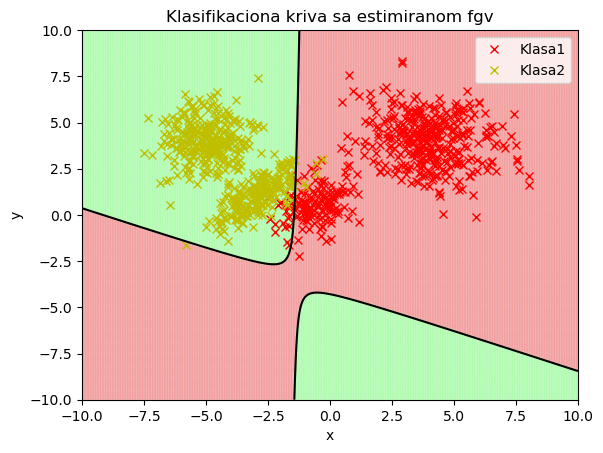

In [66]:
M1 = np.mean(X1, axis=0).reshape(-1,1)
M2 = np.mean(X2, axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)

h = np.zeros((len(x),len(y)))
T = np.log(P1/P2)

K1 = np.empty((0,2))
K2 = np.empty((0,2))

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(1,2)
        f1[i,j] = gaussian_pdf(X.T,M1,S1)
        f2[i,j] = gaussian_pdf(X.T,M2,S2)
        h[i,j] = -np.log(f1[i,j]/f2[i,j])
        if h[i,j] < T:
            K1 = np.append(K1,X,axis=0)
        else:
            K2 = np.append(K2,X,axis=0)
            
plt.figure()
plt.plot(X1[:,0],X1[:,1],'rx')
plt.plot(X2[:,0],X2[:,1],'yx')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Klasa1', 'Klasa2'])
plt.scatter(K1[:, 0], K1[:, 1], color='lightcoral', alpha=0.3, s=10, edgecolor='none')#scatter, a ne plot da se ne bi povezale sve tacne i bio bag     
plt.scatter(K2[:, 0], K2[:, 1], color='palegreen', alpha=0.3, s=10, edgecolor='none')
plt.contour(x, y, h.T, levels=[T], colors='black')
plt.title('Klasifikaciona kriva sa estimiranom fgv')
plt.show()

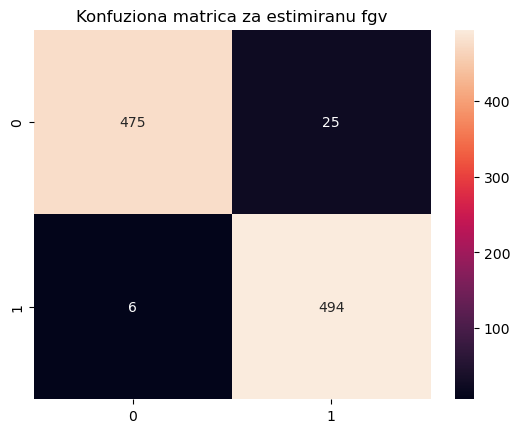

In [67]:
data = np.concatenate((X1,X2),axis=0)
M1 = np.mean(X1, axis=0).reshape(-1,1)
M2 = np.mean(X2, axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)

y_true = np.zeros(X1.shape[0]+X2.shape[0])
y_true[X1.shape[0]:] = 1
y_predict = np.zeros(np.shape(y_true))
for i in range(0,len(y_true)):
    sample = data[i,:].reshape((-1, 1))
    h = -np.log(gaussian_pdf(sample,M1,S1))+np.log(gaussian_pdf(sample,M2,S2))
    y_predict[i] = h>T

cm = confusion_matrix(y_true,y_predict)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Konfuziona matrica za estimiranu fgv')
plt.show()


Uočavamo da klasifikaciona kriva koja koristi stvarnu fgv daje bolje rezultate, me]utim i klasifikaciona kriva koja koristi procenjenu fgv odra]uje dobar posao. Takođe uočavamo da klasifikaciona kriva sa procenjenom fgv predstavlja krivu drugog reda, dok je ona koja koristi pravu fgv kriva višeg reda.

Sada računamo greške dobijene na osnovu procenjene fgv

In [68]:
eps1b = cm[0,1]/sum(cm[0,:]) 
eps2b = cm[1,0]/sum(cm[1,:])
print(f'Greška prve vrste iznosi: {eps1b:.3f}')
print(f'Greška prve vrste iznosi: {eps2b:.3f}')
e1 = 0
e2 = 0

for i in range(0,len(x)):
    for j in range(0,len(y)):
        if -np.log(f1[i,j]/f2[i,j]) < 0:
            e2 += f2[i,j]*0.1*0.1
        else:
            e1 += f1[i,j]*0.1*0.1
            
print('Greška prve vrste teorijski iznosi: ', e1)
print('Greška druge vrste teorijski iznosi: ', e2)

Greška prve vrste iznosi: 0.050
Greška prve vrste iznosi: 0.012
Greška prve vrste teorijski iznosi:  0.04787945243437909
Greška druge vrste teorijski iznosi:  0.027052146602492902


Razlika u greškama se javlja zbog greške prilikom numeričke integracije, kao i zbog relativno malog broja odbiraka nad kojima procenjujemo eksperimentalnu grešku.

### d) Bajesov test minimalne cene

Proces je analogan procesu projektovanja Bajesovog klasifikatora minimalne verovatnoće greške. Ovde dolazi samo do jednog dodatka, uvodimo cene, gde će cena $C_{ij}$ predstavljati cenu odluke da odbirak pripada klasi i, a on u stvari pripada klasi j. Sada umesto očekivane verovatnoće greške minimizujemo očekivani rizik, koji uračunava cene $$r = min(r_1(x), r_2(x))$$ $$r_1(x) = c_{11}q_1(x) + c_{12}q_2(x)$$ $$r_2(x) = c_{21}q_1(x) + c_{22}q_2(x)$$

Oblik klasifikacione funkcije je isti kao kod Bajesovog klasifikatora minimalne verovatnoće greške, jedino se menja izraz za prag, koji sada postaje:$$T = ln \left( \frac{C_{21} - C_{11}}{C_{12} - C_{22}} \cdot \frac{P_1}{P_2} \right)$$

Prema tekstu zadatka treba da važi $C_{21} > C_{12}$.

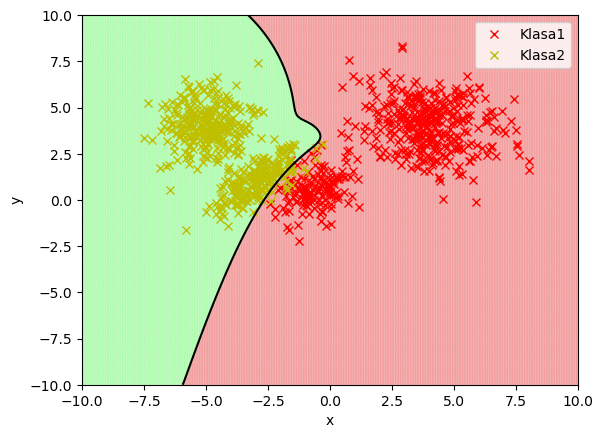

In [70]:
c11 = 0
c22 = 0
c12 = 1
c21 = 4
T = np.log(P1/P2*(c21-c11)/(c12-c22))

h = np.zeros((len(x),len(y)))

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(-1,1)
        f11[i,j] = gaussian_pdf(X,M11,S11)
        f12[i,j] = gaussian_pdf(X,M12,S12)
        f21[i,j] = gaussian_pdf(X,M21,S21)
        f22[i,j] = gaussian_pdf(X,M22,S22)
        f1[i,j] = P11*f11[i,j] + P12*f12[i,j]
        f2[i,j] = P21*f21[i,j] + P22*f22[i,j]

K1 = np.empty((0,2))
K2 = np.empty((0,2))

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(1,2)
        h[i,j] = -np.log(f1[i,j]/f2[i,j])
        if h[i,j] < T:
            K1 = np.append(K1,X,axis=0)
        else:
            K2 = np.append(K2,X,axis=0)
            
plt.figure()
plt.plot(X1[:,0],X1[:,1],'rx')
plt.plot(X2[:,0],X2[:,1],'yx')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Klasa1', 'Klasa2'])
plt.scatter(K1[:, 0], K1[:, 1], color='lightcoral', alpha=0.3, s=10, edgecolor='none')
plt.scatter(K2[:, 0], K2[:, 1], color='palegreen', alpha=0.3, s=10, edgecolor='none')
plt.contour(x, y, h.T, levels=[T], colors='black')
plt.show()

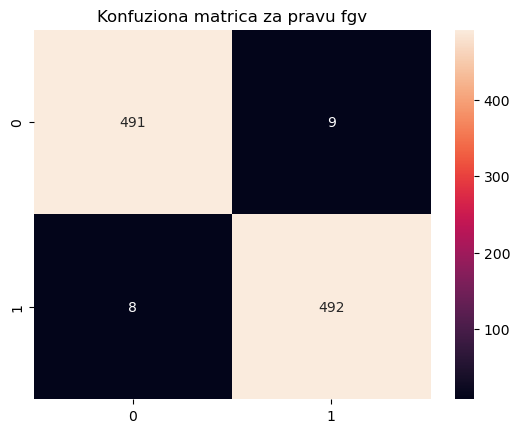

In [78]:
data = np.concatenate((X1,X2),axis=0)

y_true = np.zeros(X1.shape[0]+X2.shape[0]) 
y_true[X1.shape[0]:] = 1
y_predict = np.zeros(np.shape(y_true))

for i in range(0,len(y_true)):
    sample = data[i,:].reshape((-1, 1))
    h = -P11 * np.log(gaussian_pdf(sample,M11,S11)) - P12 * np.log(gaussian_pdf(sample,M12,S12)) + P21 * np.log(gaussian_pdf(sample,M21,S21)) + P22 * np.log(gaussian_pdf(sample,M22,S22))
    y_predict[i] = h>T

cm = confusion_matrix(y_true,y_predict)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Konfuziona matrica za pravu fgv')
plt.show()

In [79]:
eps1c = cm[0,1]/sum(cm[0,:]) 
eps2c = cm[1,0]/sum(cm[1,:])

print(f'Greška prve vrste iznosi: {eps1c:.3f}')
print(f'Greška druge vrste iznosi: {eps2c:.3f}')

Greška prve vrste iznosi: 0.018
Greška druge vrste iznosi: 0.016


Zaista uočavamo da je greška prve vrste sada manja, međutim zato je došlo do poraste greške druge vrste. Ponovićemo i za pravu fgv.

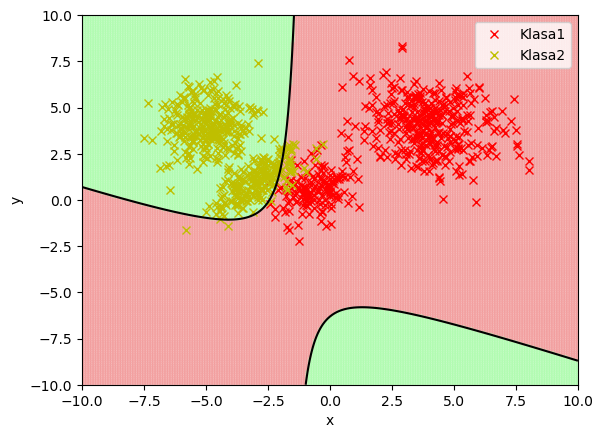

In [74]:
M1 = np.mean(X1, axis=0).reshape(-1,1)
M2 = np.mean(X2, axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)


c11 = 0
c22 = 0
c12 = 1
c21 = 4
T = np.log(P1/P2*(c21-c11)/(c12-c22))

h = np.zeros((len(x),len(y)))

K1 = np.empty((0,2))
K2 = np.empty((0,2))

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(1,2)
        f1[i,j] = gaussian_pdf(X.T,M1,S1)
        f2[i,j] = gaussian_pdf(X.T,M2,S2)
        h[i,j] = -np.log(f1[i,j]/f2[i,j])
        if h[i,j] < T:
            K1 = np.append(K1,X,axis=0)
        else:
            K2 = np.append(K2,X,axis=0)
            
plt.figure()
plt.plot(X1[:,0],X1[:,1],'rx')
plt.plot(X2[:,0],X2[:,1],'yx')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Klasa1', 'Klasa2'])
plt.scatter(K1[:, 0], K1[:, 1], color='lightcoral', alpha=0.3, s=10, edgecolor='none')#scatter, a ne plot da se ne bi povezale sve tacne i bio bag     
plt.scatter(K2[:, 0], K2[:, 1], color='palegreen', alpha=0.3, s=10, edgecolor='none')
plt.contour(x, y, h.T, levels=[T], colors='black')
plt.show()

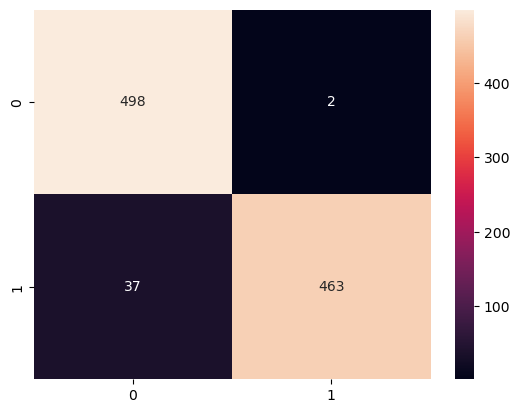

In [75]:
data = np.concatenate((X1,X2),axis=0)
M1 = np.mean(X1, axis=0).reshape(-1,1)
M2 = np.mean(X2, axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)

y_true = np.zeros(X1.shape[0]+X2.shape[0])
y_true[X1.shape[0]:] = 1
y_predict = np.zeros(np.shape(y_true))
for i in range(0,len(y_true)):
    sample = data[i,:].reshape((-1, 1))
    h = -np.log(gaussian_pdf(sample,M1,S1))+np.log(gaussian_pdf(sample,M2,S2))
    y_predict[i] = h>T

cm = confusion_matrix(y_true,y_predict)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

In [76]:
eps1c = cm[0,1]/sum(cm[0,:]) 
eps2c = cm[1,0]/sum(cm[1,:])

print(f'Greška prve vrste iznosi: {eps1c:.3f}')
print(f'Greška druge vrste iznosi: {eps2c:.3f}')

Greška prve vrste iznosi: 0.004
Greška druge vrste iznosi: 0.074


### e) Neyman-Pearson-ov test

Potrebno je odrediti $\epsilon_0$ i $\mu$. Prag je sada definisan kao: $$T = -ln~\mu$$

$\epsilon_0$ možemo inicijalizovati na zbir grešaka prvog i drugog tipa koje smo dobili za Bajesov klasifikator minimalne verovatnoće greške i nadati se da $\epsilon_1$ teži nuli, jer smo "sve greške" smestili u grešku drugog tipa, ali to ne mora uvek biti slučaj. Svakako ovo je dobra polazna tačka i dodatne promene $\epsilon_0$ mogu se vršiti nakon provere performansi klasifiktora.

Pošto nije jednostavno iz zadatog $\epsilon_0$ dobiti $\mu$, mi ćemo sračunati procenu greške drugog tipa ta različite vrednosti $\mu$, a potom odabrati $\mu$ za traženo $\epsilon_0$. Potom ćemo projektovati klasifikator.

Koristićemo estimiranu fgv

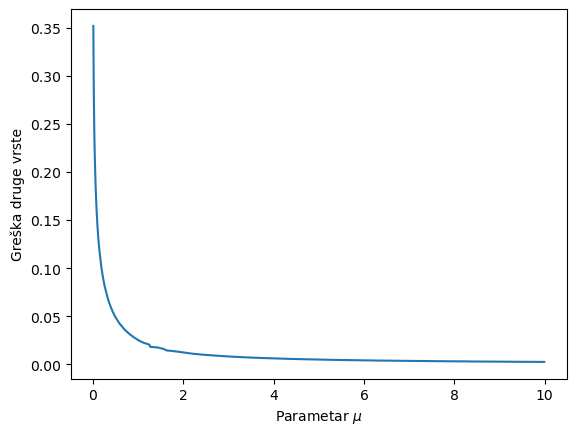

In [80]:
M1 = np.mean(X1, axis=0).reshape(-1,1)
M2 = np.mean(X2, axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)

x = np.arange(-10,10.1,0.1)     
y = np.arange(-10,10.1,0.1)

f1 = np.zeros((len(x), len(y)))
f2 = np.zeros((len(x), len(y)))
h = np.zeros((len(x), len(y)))

for i in range(len(x)):
    for j in range(len(y)):
        X = np.array([x[i], y[j]]).reshape(2,1)
        f1[i,j] = gaussian_pdf(X,M1,S1)
        f2[i,j] = gaussian_pdf(X,M2,S2)
        h[i,j] = -np.log(f1[i,j]/f2[i,j])

mu = np.arange(0.01, 10, 0.01)
eps2 = np.zeros(len(mu))

for m in range(len(mu)):
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            if h[i, j] < -np.log(mu[m]):
                eps2[m] = eps2[m] + (f2[i,j] + f2[i+1,j] + f2[i, j+1] + f2[i+1,j+1])/4*0.1*0.1                               

plt.figure()
plt.plot(mu,eps2)
plt.xlabel('Parametar $\mu$')
plt.ylabel('Greška druge vrste')
plt.show()    


In [81]:
eps0 = eps1b + eps2b
for i in range(len(eps2)):
    if(eps2[i]<=eps0):
        break
        
mu_opt = mu[i]
print('Optimalna vrednost ', mu_opt)

Optimalna vrednost  0.38


In [82]:
T = -np.log(mu_opt)

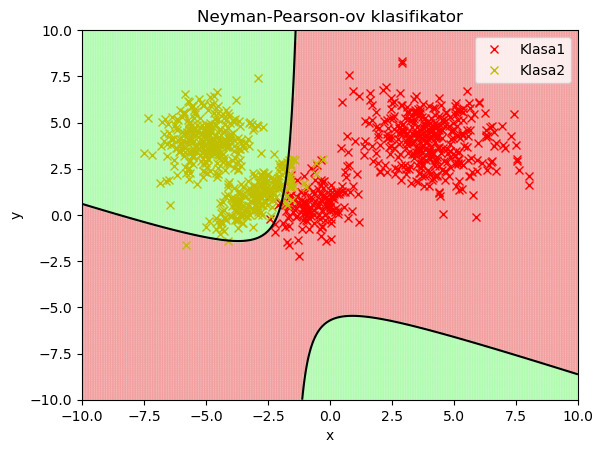

In [83]:
h = np.zeros((len(x),len(y)))

K1 = np.empty((0,2))
K2 = np.empty((0,2))

for i in range(0,len(x)):
    for j in range(0,len(y)):
        X = np.array([x[i],y[j]]).reshape(1,2)
        f1[i,j] = gaussian_pdf(X.T,M1,S1)
        f2[i,j] = gaussian_pdf(X.T,M2,S2)
        h[i,j] = -np.log(f1[i,j]/f2[i,j])
        if h[i,j] < T:
            K1 = np.append(K1,X,axis=0)
        else:
            K2 = np.append(K2,X,axis=0)
            
plt.figure()
plt.plot(X1[:,0],X1[:,1],'rx')
plt.plot(X2[:,0],X2[:,1],'yx')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['Klasa1', 'Klasa2'])
plt.scatter(K1[:, 0], K1[:, 1], color='lightcoral', alpha=0.3, s=10, edgecolor='none')#scatter, a ne plot da se ne bi povezale sve tacne i bio bag     
plt.scatter(K2[:, 0], K2[:, 1], color='palegreen', alpha=0.3, s=10, edgecolor='none')
plt.contour(x, y, h.T, levels=[T], colors='black')
plt.title('Neyman-Pearson-ov klasifikator')
plt.show()

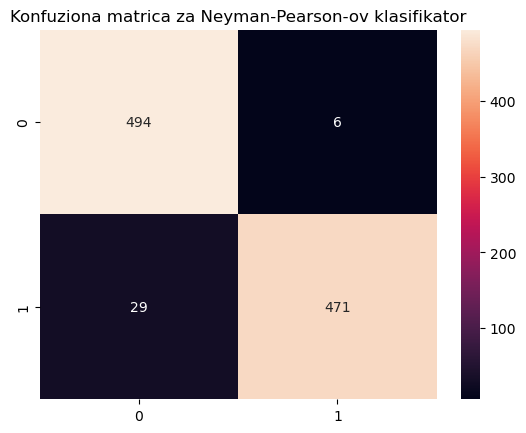

In [84]:
data = np.concatenate((X1,X2),axis=0)
M1 = np.mean(X1, axis=0).reshape(-1,1)
M2 = np.mean(X2, axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)

y_true = np.zeros(X1.shape[0]+X2.shape[0])
y_true[X1.shape[0]:] = 1
y_predict = np.zeros(np.shape(y_true))
for i in range(0,len(y_true)):
    sample = data[i,:].reshape((-1, 1))
    h = -np.log(gaussian_pdf(sample,M1,S1))+np.log(gaussian_pdf(sample,M2,S2))
    y_predict[i] = h>T

cm = confusion_matrix(y_true,y_predict)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Konfuziona matrica za Neyman-Pearson-ov klasifikator')
plt.show()

I ovde se može uočiti da je greška prve vrste manja u odnosu na onu inicijalnu kod BTMVG.

In [85]:
eps1n = cm[0,1]/sum(cm[0,:]) 
eps2n = cm[1,0]/sum(cm[1,:])

print(f'Greška prve vrste iznosi: {eps1n:.3f}')
print(f'Greška druge vrste iznosi: {eps2n:.3f}')

Greška prve vrste iznosi: 0.012
Greška druge vrste iznosi: 0.058


### f) Wald-ov test
Definišemo $S_m$ kao $$S_m = \sum_{i=1}^{m} h(X_i)$$, gde je $$h(x) = -ln \left( \frac{f_1(x)}{f_2(x)} \right)$$


Odluka se donosi na sledeći način $$Sm \left\{\begin{array}{lc}>b &  X_i \in \omega_2  \\ < a & X_i \in \omega_1  \\ \in (a,~b) & \text {uzmi (m+1) odbirak} \end{array}\right.$$

$~~$
$$a = - ln \left( \frac{1-\epsilon_1}{\epsilon_2} \right)$$
$~$

$$b = - ln \left( \frac{\epsilon_1}{1-\epsilon_2} \right)$$

Ovaj test je pogodno koristiti kada nam odbirci stižu jedan po jedan (sekvencijalno) i kada treba donositi odluku u realnom vremenu.

Takođe za očekivanti broj potrebnih odbiraka prve, odnosno druge klase se pokazuje da važi: $$m_1 = \frac{(1-\epsilon_1)ln \left(\frac{\epsilon_2}{1-\epsilon_1} \right) - \epsilon_1 ln\left(\frac{\epsilon_1}{1-\epsilon_2} \right)}{\eta_1}$$ izraz za $m_2$ se dobnija analogno zamenom a i b u izraz $$m_2 = \frac{b(1-\epsilon_2) + a\epsilon_2}{\eta_2}$$ 

In [109]:
eps1w_arr = np.logspace(-7, -0.1, num=12)
eps2w_arr = np.logspace(-7, -0.1, num=12)
m1 = np.zeros((len(eps1w_arr), len(eps2w_arr)))
m2 = np.zeros((len(eps1w_arr), len(eps2w_arr)))
data = np.concatenate((X1,X2),axis=0).T

In [110]:
for i in range(len(eps1w_arr)):
    for j in range(len(eps2w_arr)):
        eps1w = eps1w_arr[i]
        eps2w = eps2w_arr[j]
        A = (1-eps1w) / eps2w
        B = eps1w / (1-eps2w)
        a = -np.log(A)
        b = -np.log(B)
        
        Sm = 0
        cnt = 0
        
        samples1 = []
        samples2 = []
        
        for n in range(data.shape[1]):
            f1 = gaussian_pdf(data[:,n].reshape(-1,1), M1, S1)
            f2 = gaussian_pdf(data[:,n].reshape(-1,1), M2, S2)
            h = -np.log(f1/f2)
            Sm += h
            cnt += 1
            
            if Sm < a:
                samples1.append(cnt)
                Sm = 0
                cnt = 0
            if Sm > b:
                samples2.append(cnt)
                Sm = 0
                cnt = 0
        
        if len(samples1) > 0:
            m1[i,j] = sum(samples1)/len(samples1)
        if len(samples2) > 0:
            m2[i,j] = sum(samples2)/len(samples2)  

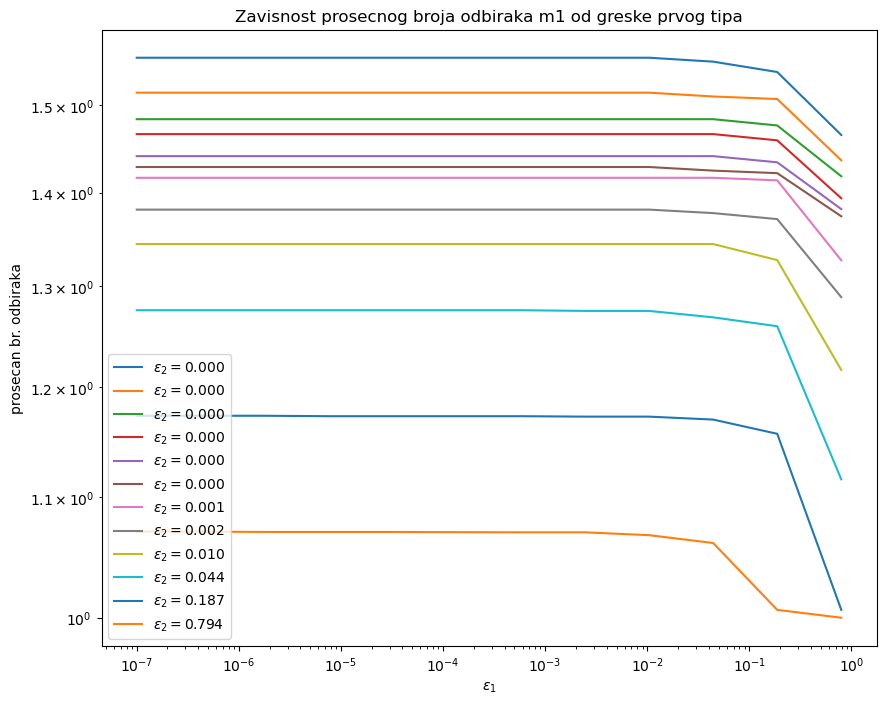

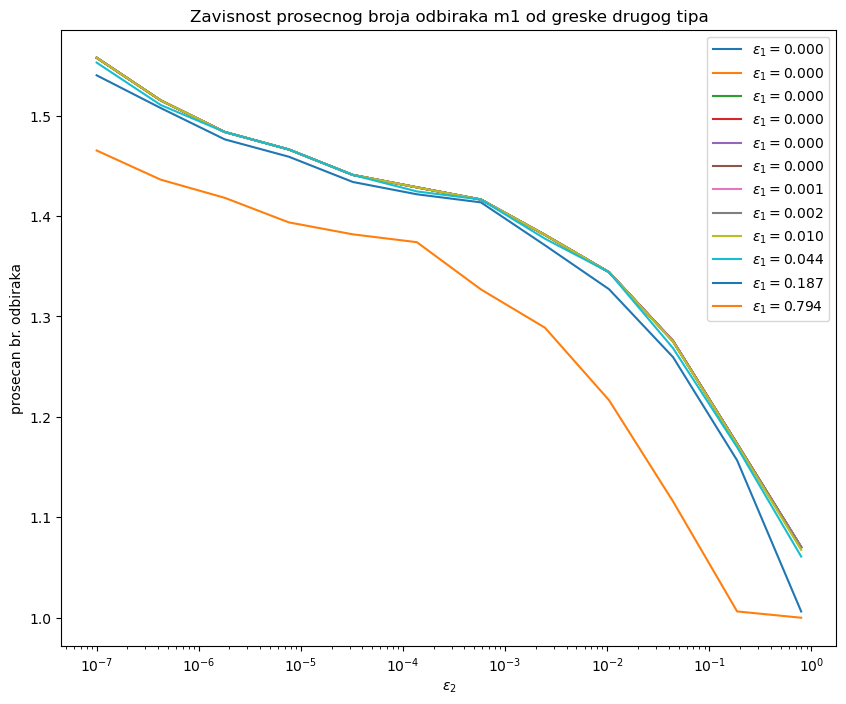

In [113]:
plt.figure(figsize=(10,8))
for j in range(len(eps2w_arr)):
    plt.plot(eps1w_arr, m1[:, j])
plt.legend([f'$\epsilon_2 = {elem:.3f}$' for elem in eps2w_arr])
plt.title('Zavisnost prosecnog broja odbiraka m1 od greske prvog tipa')
plt.xlabel('$\epsilon_1$')
plt.ylabel('prosecan br. odbiraka')
plt.xscale('log')
plt.yscale('log')
plt.show()


plt.figure(figsize=(10,8))
for i in range(len(eps1w_arr)):
    plt.plot(eps2w_arr, m1[i, :])
plt.legend([f'$\epsilon_1 = {elem:.3f}$' for elem in eps1w_arr])
plt.title('Zavisnost prosecnog broja odbiraka m1 od greske drugog tipa')
plt.xlabel('$\epsilon_2$')
plt.ylabel('prosecan br. odbiraka')
plt.xscale('log')
#plt.yscale('log')
plt.show()

Uočavamo da grafici imaju približan oblik kao oni sa predavanja. Sada ćemo skicirati grafike i za očekivani broj odbiraka iz druge klase.

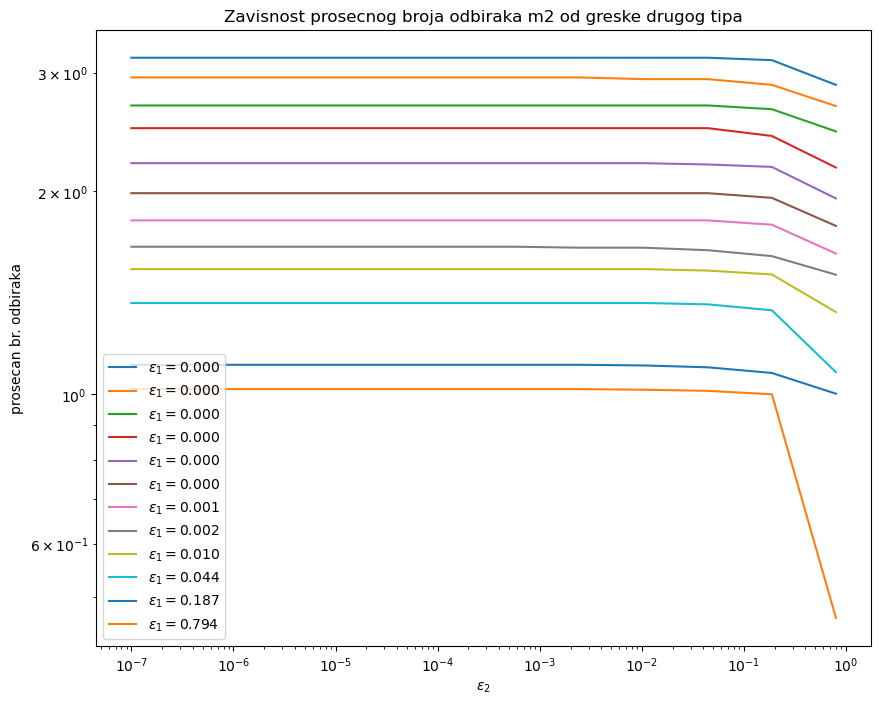

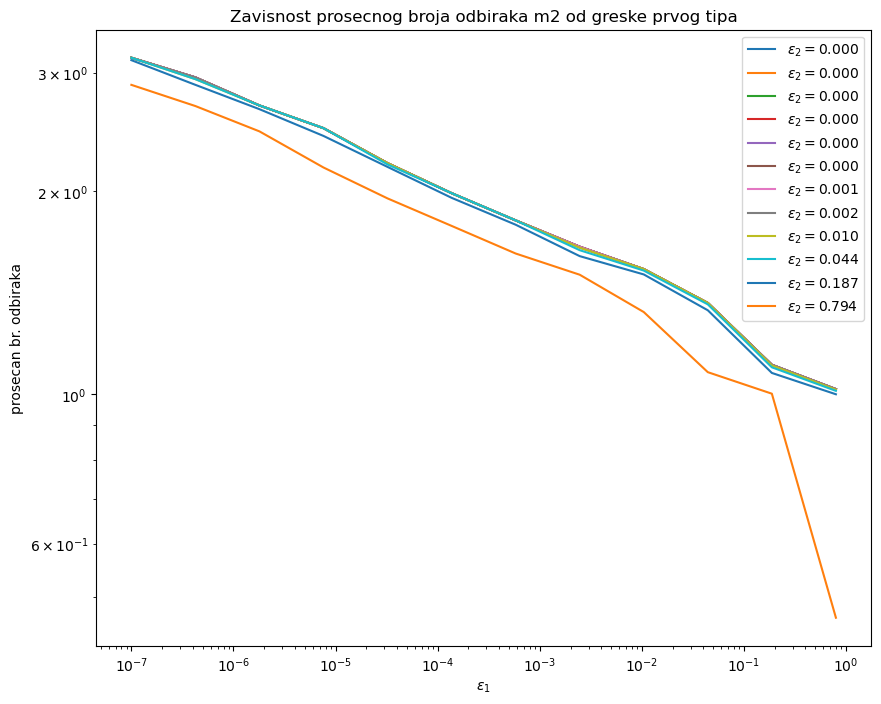

In [117]:
plt.figure(figsize=(10,8))
for i in range(len(eps1w_arr)):
    plt.plot(eps2w_arr, m2[i, :])
plt.legend([f'$\epsilon_1 = {elem:.3f}$' for elem in eps1w_arr])
plt.title('Zavisnost prosecnog broja odbiraka m2 od greske drugog tipa')
plt.xlabel('$\epsilon_2$')
plt.ylabel('prosecan br. odbiraka')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.figure(figsize=(10,8))
for j in range(len(eps2w_arr)):
    plt.plot(eps1w_arr, m2[:, j])
plt.legend([f'$\epsilon_2 = {elem:.3f}$' for elem in eps2w_arr])
plt.title('Zavisnost prosecnog broja odbiraka m2 od greske prvog tipa')
plt.xlabel('$\epsilon_1$')
plt.ylabel('prosecan br. odbiraka')
plt.xscale('log')
plt.yscale('log')
plt.show()

#### Klasifikacija

Fiksiraćemo obe greške na vrednost 0.01 i izvršiti klasifikaciju generisanih odbiraka

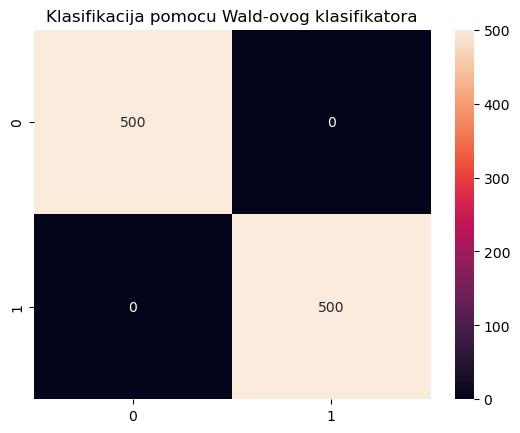

Greška prve vrste iznosi: 0.000
Greška druge vrste iznosi: 0.000


In [119]:
eps1w = 0.01
eps2w = 0.01
A = (1-eps1w) / eps2w
B = eps1w / (1-eps2w)
a = -np.log(A)
b = -np.log(B)
        
y_true = np.zeros(data.shape[1]) 
y_true[X1.shape[0]:] = 1
y_predict = np.zeros(np.shape(y_true))
start = 0 
Sm = 0

M1 = X1.mean(axis=0).reshape(-1,1)
M2 = X2.mean(axis=0).reshape(-1,1)
S1 = np.cov(X1.T)
S2 = np.cov(X2.T)

for n in range(data.shape[1]):
    f1 = gaussian_pdf(data[:,n].reshape(-1,1), M1, S1)
    f2 = gaussian_pdf(data[:,n].reshape(-1,1), M2, S2)
    h = -np.log(f1/f2)
    Sm += h

    if(Sm < a ):
        y_predict[start:n+1] = 0
        start = n+1
        Sm = 0
    elif(Sm > b):
        y_predict[start:n+1] = 1
        start = n+1
        Sm = 0

cm = confusion_matrix(y_true,y_predict)
plt.figure()
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Klasifikacija pomocu Wald-ovog klasifikatora')
plt.show()

print(f'Greška prve vrste iznosi: {cm[0,1]/sum(cm[0,:]):.3f}')
print(f'Greška druge vrste iznosi: {cm[1,0]/sum(cm[1,:]):.3f}')